## Per-step DDPG (Basic example)

This is a basic test of the DDPG per-step module.

In [1]:
# GLOBAL IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta, date
import gym
# deque and random
from collections import deque
import random
#import sys
import torch as th
from torch import nn
from torch import optim
from drl_pfopt import (PortfolioOptEnv, FeatureEngineer, data_split, AlpacaDownloader, YahooDownloader)
from dual_timeframe_XP import (PFOptDualTFEnv, FeatureEngDualTF, data_dict_split)
# Import class
from DDPGPS import DDPGPS_Agent

/usr/local/lib/python3.9/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


### (1) Data loading, processing and splitting

The usual...

In [2]:
# Load DJIA file 
df_Alpaca_15min = pd.read_csv(filepath_or_buffer="datasets/Alpaca_DJIA_15min_2208-2211.csv",
                           usecols = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic'])
TICKER_LIST = ['AXP', 'BA', 'CVX', 'JNJ', 'KO']


# Reduce to 10 stocks
df_file = df_Alpaca_15min[df_Alpaca_15min.tic.isin(TICKER_LIST)].copy()
del df_Alpaca_15min

In [3]:
# Feature Engineer params
trade_timeframe = "Hour"
trade_ext_hours = True
N_lookback_trade_prds = 15
tech_ind_list = ["turbulence"]
use_return_covs = True

# Instantiate feature eng. object
processor = FeatureEngDualTF(tech_indicator_list = tech_ind_list,
                             use_return_covs = use_return_covs,
                             data_source = "Alpaca")


# Preprocess data
data_dict = processor.preprocess_data(df_X = df_file,
                                      trade_timeframe = trade_timeframe,
                                      trade_ext_hours = trade_ext_hours,
                                      N_lookback_trade_prds = N_lookback_trade_prds,)

Chosen data source is Alapaca API. Use set_Alpaca_parameters()
to provide the following parameters:
api_key (str), api_secret (str).
Successfully computed asset returns and their covariances
Successfully added technical indicators
Successfully added turbulence index


In [4]:
# Data split
split_date = "2022-10-18"
data_dict_train, data_dict_test = data_dict_split(data_dict, split_date)

Now we create the environments corresponding to these datasets:

In [5]:
# Env parameters
#state_struct_list = ["volume", "close_returns", "returns_cov", "weights"]
state_struct_list = ["close_returns", "weights"]
weight_normalization = "identity"#"softmax"#"relu"
transaction_cost_pct = 0.0
reward_type = "portfolio_return"
pf_value_ini = 100000.0
plot_prds_end_episode=40

# Training environment
env_train = PFOptDualTFEnv(data_dict = data_dict_train,
                     pf_value_ini = pf_value_ini,
                     reward_type = reward_type,
                     state_struct_list = state_struct_list,
                     tech_ind_list = tech_ind_list,
                     transaction_cost_pct = transaction_cost_pct,
                     weight_normalization = weight_normalization,
                     plot_prds_end_episode=plot_prds_end_episode,)

# Testing environment
env_test = PFOptDualTFEnv(data_dict = data_dict_test,
                     pf_value_ini = pf_value_ini,
                     reward_type = reward_type,
                     state_struct_list = state_struct_list,
                     tech_ind_list = tech_ind_list,
                     transaction_cost_pct = transaction_cost_pct,
                     weight_normalization = weight_normalization,
                     plot_prds_end_episode=plot_prds_end_episode,)

print(f"obs_space_shape = {env_train.obs_space_shape}")

obs_space_shape = (65, 5)


### (2) **DDPGPS_Agent Tests**


#### 2.a - Class Training test

In [6]:
# Instantiate agent
Agent = DDPGPS_Agent(train_env = env_train,
                    model_fname = "DDPGPS_Test_0")

**IMPORTANT:** This agent is extremely sensitive the the network architecture. The parameter values below are the only ones I found that don't get the training stuck at some local optimum.

In [7]:
# Model parameters
actor_net_in_dim = env_train.obs_space_shape[0]*env_train.obs_space_shape[1]
n_hidden_1 = 250#actor_net_in_dim*4
n_hidden_2 = 50#actor_net_in_dim*2
actor_net_out_dim = env_train.n_assets
weight_normalization = 'softmax'
activation_fn = 'identity'
activation_scale = 1.0
buffer_size = 512
learn_rate = 0.001

# Create model
Agent.set_model(actor_n_hidden_1 = n_hidden_1,
                actor_n_hidden_2 = n_hidden_2,
                weight_normalization = weight_normalization,
                activation_fn = activation_fn,
                activation_scale = activation_scale,
                buffer_size = buffer_size,
                learn_rate = learn_rate,)

Per-step DDPG agent with given parameters has been successfully created.


True

Initial portfolio value: 100000.0
End portfolio value: [100084.69493466]
Yearly Sharpe ratio at last period: 0.040588195359597304
Initial portfolio value: 100000.0
End portfolio value: [109591.88240183]
Yearly Sharpe ratio at last period: 0.4119671228569287
Initial portfolio value: 100000.0
End portfolio value: [100394.18191744]
Yearly Sharpe ratio at last period: 0.05483290449751853
Initial portfolio value: 100000.0
End portfolio value: [106509.28137597]
Yearly Sharpe ratio at last period: 0.28632313689730826
######################################################
              TRAINING EPISODE: 4
######################################################
Average reward = 4.914908878461688e-05 (portfolio return)
Average policy loss = -0.0004883535439148545
######################################################
Initial portfolio value: 100000.0
End portfolio value: [104988.63501419]
Yearly Sharpe ratio at last period: 0.23386622991343667
Initial portfolio value: 100000.0
End portfolio value

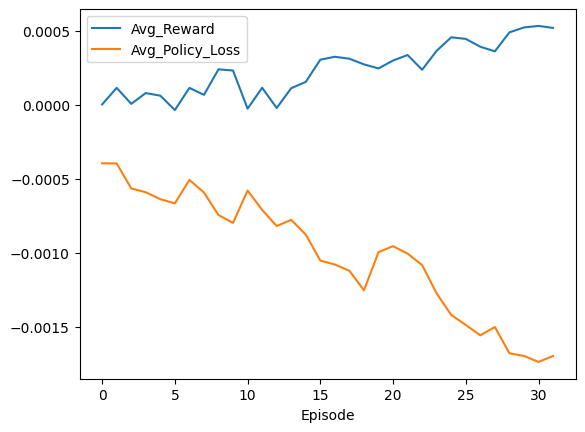

In [8]:
# Learning params
n_train_rounds = 32
batch_size = 128

# Train the model
average_reward_hist, average_policy_loss_hist\
    = Agent.train_model(n_train_rounds = n_train_rounds,
                        batch_size = batch_size,
                        show_env_plots=False
                       )

#### 2.b - Class backtest

Try a backtest for good measure.

Initial portfolio value: 100000.0
End portfolio value: [102996.88507923]
Yearly Sharpe ratio at last period: 0.6341006331543669
Plotting portfolio values and weights for last 40 periods:


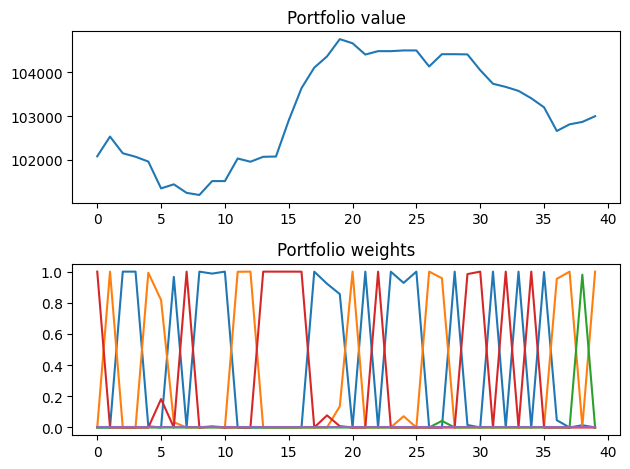

Finished running backtest. Storing results...


/usr/local/lib/python3.9/dist-packages/pyfolio/timeseries.py:730: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [9]:
# Backtest
backtest_result_dict = Agent.run_backtest(test_env = env_test)

In [10]:
backtest_result_dict.keys()

dict_keys(['value_hist', 'return_hist', 'weights_hist', 'agt_actions_hist', 'performance_stats'])

In [11]:
type(backtest_result_dict["value_hist"])

pandas.core.frame.DataFrame

<AxesSubplot: >

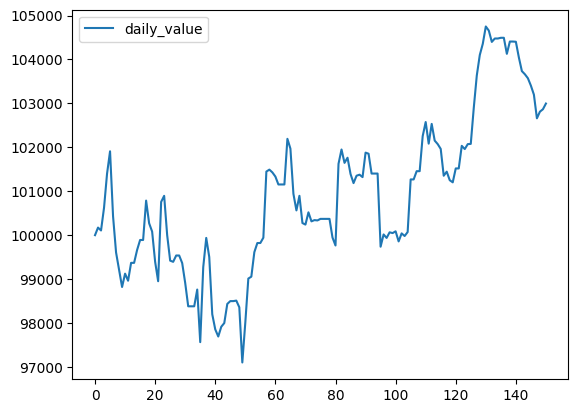

In [10]:
backtest_result_dict["value_hist"].plot()

<AxesSubplot: >

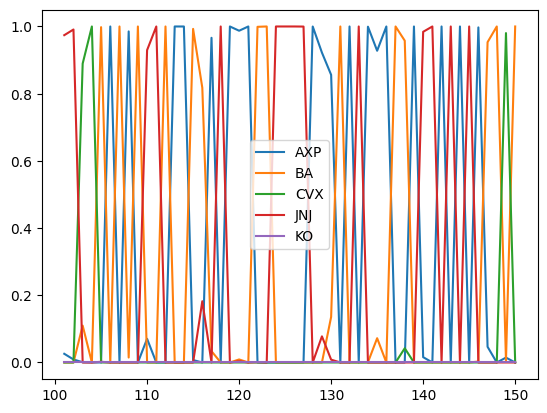

In [11]:
backtest_result_dict["agt_actions_hist"].iloc[-50:].plot()